In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [4]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

print x_i.shape
print compute_V(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print compute_V(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

print many_x_i
print compute_V_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
Variable containing:
 2.2100
[torch.FloatTensor of size 1]

Variable containing:
 6.0500
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
  2.2100   6.0500  13.0000
[torch.FloatTensor of size 1x3]



In [6]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_policy(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(x - x_desired_vectorized)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
-3.4585
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-6.8088
[torch.FloatTensor of size 2]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
  1.1000   2.2000   3.0000
 -3.4585  -6.8088 -10.0907
[torch.FloatTensor of size 2x3]



In [7]:
def compute_Vdot(x):
    V = compute_V(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
-5.4088
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
 -5.4088
-25.1187
-48.5442
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [8]:
K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
 2.2911
 0.1341
[torch.FloatTensor of size 2]



## Now let's search for K, from an initialization not stable

In [8]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.4195
 0.9967
[torch.FloatTensor of size 2]

Initial K Variable containing:
-0.3814
-0.9422
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
-2.0155
-0.3594
[torch.FloatTensor of size 2]



In [9]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(2).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


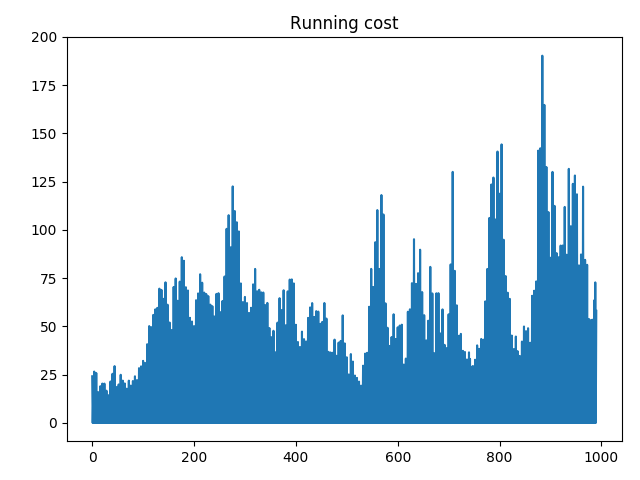

In [14]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [15]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-4
slack_var = .00

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = 0.2*(torch.rand(2,num_samples_per_iteration).type(dtype)*2 - torch.ones(2,num_samples_per_iteration))
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 68.9809
 37.7419
[torch.FloatTensor of size 2]

first K is Variable containing:
 1.8132
 4.0742
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0030951499939 is time for one step of grad descent

24.1789646149
P is Variable containing:
1.00000e-02 *
  1.1160
  0.6105
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8205
 4.0752
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00291991233826 is time for one step of grad descent

0.00396519014612
P is Variable containing:
  39.6094
 127.1491
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8205
 4.0752
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0028510093689 is time for one step of grad descent

12.676445961
P is Variable containing:
1.00000e-03 *
  2.2331
  7.1701
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8136
 4.

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00325322151184 is time for one step of grad descent

16.7060050964
P is Variable containing:
1.00000e-02 *
  1.0658
  0.6365
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8281
 4.0833
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00256705284119 is time for one step of grad descent

0.00264274631627
P is Variable containing:
  49.4253
 126.0840
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8281
 4.0833
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00255179405212 is time for one step of grad descent

5.8866481781
P is Variable containing:
1.00000e-03 *
  2.6949
  6.8758
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8240
 4.0835
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00257682800293 is time for one step of grad descent

0.

P is Variable containing:
1.00000e-02 *
  1.1280
  0.6278
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8244
 4.1005
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00226902961731 is time for one step of grad descent

0.0035230491776
P is Variable containing:
  37.7438
 132.1742
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8244
 4.1005
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00194811820984 is time for one step of grad descent

12.5804834366
P is Variable containing:
1.00000e-03 *
  1.9974
  6.9963
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8163
 4.1011
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00173783302307 is time for one step of grad descent

0.000634273572359
P is Variable containing:
 68.4763
 37.7949
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8163
 4.1011
[

P is Variable containing:
1.00000e-03 *
  1.5362
  7.6101
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8159
 4.1134
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0019690990448 is time for one step of grad descent

0.00129881955218
P is Variable containing:
 69.9083
 32.7878
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8159
 4.1134
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00155210494995 is time for one step of grad descent

50.1826820374
P is Variable containing:
1.00000e-02 *
  1.1728
  0.5500
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8271
 4.1153
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00161004066467 is time for one step of grad descent

0.00762680964544
P is Variable containing:
  25.4613
 119.4373
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8271
 4.1153
[t

P is Variable containing:
1.00000e-02 *
  1.1839
  0.5048
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8495
 4.1378
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00229501724243 is time for one step of grad descent

0.0100983763114
P is Variable containing:
  21.7955
 118.0190
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8495
 4.1378
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00168013572693 is time for one step of grad descent

22.3477039337
P is Variable containing:
1.00000e-03 *
  1.5127
  8.1949
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8397
 4.1387
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00160717964172 is time for one step of grad descent

0.00134555366822
P is Variable containing:
 71.8674
 29.8411
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8397
 4.1387
[t

P is Variable containing:
1.00000e-03 *
  1.3707
  8.1727
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8625
 4.1620
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00283002853394 is time for one step of grad descent

0.00187425652985
P is Variable containing:
 70.8581
 29.1300
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8625
 4.1620
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00274205207825 is time for one step of grad descent

73.2197723389
P is Variable containing:
1.00000e-02 *
  1.2076
  0.4963
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8760
 4.1647
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00280094146729 is time for one step of grad descent

0.0121807735413
P is Variable containing:
  17.6943
 114.8887
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8760
 4.1647
[t

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00329899787903 is time for one step of grad descent

0.00175277201924
P is Variable containing:
 71.5495
 32.1513
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8786
 4.1877
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0017101764679 is time for one step of grad descent

50.1903305054
P is Variable containing:
1.00000e-02 *
  1.1631
  0.5225
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8897
 4.1896
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00232696533203 is time for one step of grad descent

0.00709971413016
P is Variable containing:
  26.0498
 116.3525
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8897
 4.1896
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00197410583496 is time for one step of grad descent

22.9075546265

P is Variable containing:
1.00000e-03 *
  1.6291
  8.3868
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8982
 4.2157
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00272297859192 is time for one step of grad descent

0.00179909775034
P is Variable containing:
 73.9233
 31.1925
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8982
 4.2157
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00182580947876 is time for one step of grad descent

61.2973861694
P is Variable containing:
1.00000e-02 *
  1.1486
  0.4845
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9105
 4.2180
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00173187255859 is time for one step of grad descent

0.00910528376698
P is Variable containing:
  26.4195
 111.1676
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9105
 4.2180
[

0.0029730796814 is time for one step of grad descent

100.587478638
P is Variable containing:
1.00000e-02 *
  1.1217
  0.4140
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9400
 4.2455
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00192809104919 is time for one step of grad descent

0.0130768688396
P is Variable containing:
  24.9561
 100.8499
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9400
 4.2455
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00172090530396 is time for one step of grad descent

19.0890579224
P is Variable containing:
1.00000e-03 *
  2.3116
  9.3453
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9317
 4.2463
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00188779830933 is time for one step of grad descent

0.001853857073
P is Variable containing:
 81.3600
 29.5952
[torch.Fl

0.00407004356384 is time for one step of grad descent

62.633102417
P is Variable containing:
1.00000e-02 *
  1.0856
  0.4415
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9943
 4.2819
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00222706794739 is time for one step of grad descent

0.00794233009219
P is Variable containing:
  28.8488
 102.6779
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9943
 4.2819
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00226902961731 is time for one step of grad descent

23.2262306213
P is Variable containing:
1.00000e-03 *
  2.5358
  9.0282
[torch.FloatTensor of size 2]

K is Variable containing:
 1.9842
 4.2828
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00229978561401 is time for one step of grad descent

0.00187628308777
P is Variable containing:
 79.7738
 31.8808
[torch

0.00456404685974 is time for one step of grad descent

0.00868614856154
P is Variable containing:
  27.7940
 102.5574
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0172
 4.3061
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00185084342957 is time for one step of grad descent

27.7644290924
P is Variable containing:
1.00000e-03 *
  2.4613
  9.0851
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0062
 4.3072
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00183892250061 is time for one step of grad descent

0.00225307722576
P is Variable containing:
 80.4398
 31.3237
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0062
 4.3072
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00185012817383 is time for one step of grad descent

69.0034866333
P is Variable containing:
1.00000e-02 *
  1.0797
  0.4203
[torc

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00336408615112 is time for one step of grad descent

0.00526567036286
P is Variable containing:
 37.2861
 98.2047
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0411
 4.3301
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00173592567444 is time for one step of grad descent

17.436630249
P is Variable containing:
1.00000e-03 *
  3.3790
  8.9016
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0331
 4.3308
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00203585624695 is time for one step of grad descent

0.00158860126976
P is Variable containing:
 84.5430
 37.6498
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0331
 4.3308
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00225591659546 is time for one step of grad descent

36.6205177307
P

0.00348877906799 is time for one step of grad descent

0.00222007464617
P is Variable containing:
 84.6427
 31.9993
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0536
 4.3513
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00212788581848 is time for one step of grad descent

74.2924194336
P is Variable containing:
1.00000e-02 *
  1.0339
  0.3908
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0673
 4.3540
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00264692306519 is time for one step of grad descent

0.00848550442606
P is Variable containing:
 29.8175
 98.3763
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0673
 4.3540
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00263905525208 is time for one step of grad descent

26.0747890472
P is Variable containing:
1.00000e-03 *
  2.8214
  9.3115
[torch.

P is Variable containing:
1.00000e-02 *
  1.0499
  0.4153
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0811
 4.3929
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00231194496155 is time for one step of grad descent

0.00699173100293
P is Variable containing:
 29.2866
 98.9499
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0811
 4.3929
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00199818611145 is time for one step of grad descent

30.5189170837
P is Variable containing:
1.00000e-03 *
  2.7499
  9.2939
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0694
 4.3941
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00198602676392 is time for one step of grad descent

0.00238586287014
P is Variable containing:
 82.0786
 32.0650
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0694
 4.3941
[to

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00451612472534 is time for one step of grad descent

36.3571472168
P is Variable containing:
1.00000e-03 *
  9.9307
  4.3742
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0900
 4.4136
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00248217582703 is time for one step of grad descent

0.00418190378696
P is Variable containing:
 36.9310
 96.1015
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0900
 4.4136
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00234699249268 is time for one step of grad descent

19.1930484772
P is Variable containing:
1.00000e-03 *
  3.4842
  9.0685
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0823
 4.4143
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00244092941284 is time for one step of grad descent

0.0

K is Variable containing:
 2.0970
 4.4301
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00349688529968 is time for one step of grad descent

0.00153407896869
P is Variable containing:
 85.8098
 39.9297
[torch.FloatTensor of size 2]

K is Variable containing:
 2.0970
 4.4301
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00267910957336 is time for one step of grad descent

25.1199913025
P is Variable containing:
1.00000e-03 *
  9.5816
  4.4578
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1042
 4.4310
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00253415107727 is time for one step of grad descent

0.0029906234704
P is Variable containing:
 38.8889
 95.7846
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1042
 4.4310
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2

P is Variable containing:
1.00000e-03 *
  8.7560
  2.9572
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1582
 4.4640
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00313901901245 is time for one step of grad descent

0.00978635344654
P is Variable containing:
 35.5163
 81.9687
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1582
 4.4640
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00330710411072 is time for one step of grad descent

18.1975784302
P is Variable containing:
1.00000e-02 *
  0.4451
  1.0274
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1507
 4.4647
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00310206413269 is time for one step of grad descent

0.0022991723381
P is Variable containing:
 100.1936
  36.2319
[torch.FloatTensor of size 2]

K is Variable containing:
 2.1507
 4.4647
[t

P is Variable containing:
1.00000e-03 *
  4.5887
  9.8010
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2017
 4.4879
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0019850730896 is time for one step of grad descent

0.00220115459524
P is Variable containing:
 96.8943
 37.2530
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2017
 4.4879
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00200796127319 is time for one step of grad descent

56.3104705811
P is Variable containing:
1.00000e-03 *
  8.9932
  3.4569
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2139
 4.4900
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00194597244263 is time for one step of grad descent

0.00507076689973
P is Variable containing:
 38.9297
 85.1400
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2139
 4.4900
[tor

0.00312399864197 is time for one step of grad descent

58.8798446655
P is Variable containing:
1.00000e-03 *
  9.2934
  3.4940
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2273
 4.5099
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00189208984375 is time for one step of grad descent

0.00539187714458
P is Variable containing:
 34.4108
 87.2554
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2273
 4.5099
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00193500518799 is time for one step of grad descent

26.8401031494
P is Variable containing:
1.00000e-03 *
  3.9113
  9.9202
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2174
 4.5109
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00183200836182 is time for one step of grad descent

0.0029561414849
P is Variable containing:
 94.7688
 33.9951
[torch.F

K is Variable containing:
 2.2411
 4.5415
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00232481956482 is time for one step of grad descent

52.9761924744
P is Variable containing:
1.00000e-03 *
  9.6601
  3.6113
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2522
 4.5434
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00244092941284 is time for one step of grad descent

0.00556736532599
P is Variable containing:
 33.4772
 88.8551
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2522
 4.5434
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00278091430664 is time for one step of grad descent

34.1148681641
P is Variable containing:
1.00000e-03 *
  3.7130
  9.8574
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2410
 4.5446
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torc

0.0040111541748 is time for one step of grad descent

0.0118874283507
P is Variable containing:
 35.0763
 81.6595
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2779
 4.5845
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0026319026947 is time for one step of grad descent

26.129907608
P is Variable containing:
1.00000e-02 *
  0.4441
  1.0341
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2682
 4.5855
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00245714187622 is time for one step of grad descent

0.00320377852768
P is Variable containing:
 101.8362
  35.5606
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2682
 4.5855
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00230813026428 is time for one step of grad descent

78.8160400391
P is Variable containing:
1.00000e-03 *
  8.7540
  3.0561
[torch.Fl

P is Variable containing:
1.00000e-03 *
  9.1636
  3.6280
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2766
 4.6163
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0031111240387 is time for one step of grad descent

0.00348601560108
P is Variable containing:
 36.0787
 87.2249
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2766
 4.6163
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00311899185181 is time for one step of grad descent

26.2456550598
P is Variable containing:
1.00000e-03 *
  4.0493
  9.7918
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2665
 4.6174
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0039370059967 is time for one step of grad descent

0.00361018651165
P is Variable containing:
 92.4815
 35.2299
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2665
 4.6174
[torc

0.00404095649719 is time for one step of grad descent

0.00494722928852
P is Variable containing:
 91.8117
 26.3467
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2952
 4.6653
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00270104408264 is time for one step of grad descent

144.345596313
P is Variable containing:
1.00000e-02 *
  1.0065
  0.2887
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3154
 4.6705
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00248312950134 is time for one step of grad descent

0.0155016649514
P is Variable containing:
 28.2354
 89.1151
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3154
 4.6705
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00224995613098 is time for one step of grad descent

44.0965614319
P is Variable containing:
1.00000e-02 *
  0.3231
  1.0200
[torch.F

P is Variable containing:
1.00000e-03 *
  3.6889
  9.5601
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2872
 4.7080
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00348615646362 is time for one step of grad descent

0.00355616910383
P is Variable containing:
 90.4516
 34.0114
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2872
 4.7080
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00319218635559 is time for one step of grad descent

47.5644073486
P is Variable containing:
1.00000e-03 *
  9.6881
  3.6420
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2980
 4.7097
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0035080909729 is time for one step of grad descent

0.00478203548118
P is Variable containing:
 33.0012
 91.7011
[torch.FloatTensor of size 2]

K is Variable containing:
 2.2980
 4.7097
[tor

K is Variable containing:
 2.3252
 4.7666
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00401711463928 is time for one step of grad descent

48.9233894348
P is Variable containing:
1.00000e-02 *
  0.2920
  1.0071
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3116
 4.7682
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00313091278076 is time for one step of grad descent

0.0055354363285
P is Variable containing:
 87.1868
 27.2318
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3116
 4.7682
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00260496139526 is time for one step of grad descent

85.6079788208
P is Variable containing:
1.00000e-02 *
  1.0452
  0.3264
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3251
 4.7711
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch

P is Variable containing:
1.00000e-02 *
  0.2757
  1.0166
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3164
 4.8397
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00178289413452 is time for one step of grad descent

0.0056914081797
P is Variable containing:
 87.6523
 25.5363
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3164
 4.8397
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00226187705994 is time for one step of grad descent

118.481063843
P is Variable containing:
1.00000e-02 *
  1.0518
  0.3063
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3330
 4.8436
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.0025999546051 is time for one step of grad descent

0.0140544511378
P is Variable containing:
 24.7540
 90.8989
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3330
 4.8436
[torch

P is Variable containing:
1.00000e-02 *
  1.0606
  0.3616
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3226
 4.8756
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00307989120483 is time for one step of grad descent

0.00698606017977
P is Variable containing:
 27.0973
 96.9564
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3226
 4.8756
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00361895561218 is time for one step of grad descent

53.4934883118
P is Variable containing:
1.00000e-03 *
  2.6732
  9.5685
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3085
 4.8772
[torch.FloatTensor of size 2]

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([1, 2])
0.00310802459717 is time for one step of grad descent

0.00513211730868
P is Variable containing:
 82.4714
 28.7917
[torch.FloatTensor of size 2]

K is Variable containing:
 2.3085
 4.8772
[to

In [16]:
print K
print P

Variable containing:
 2.2974
 4.8964
[torch.FloatTensor of size 2]

Variable containing:
 83.5755
 23.8145
[torch.FloatTensor of size 2]



## Analytical double integrator Lyapunov

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [17]:
# condition (a):  p_1 - p_2*k_1
print P[0] - P[1]*K[0]

# condition (b): k_2 > 0
print K[1]


Variable containing:
 28.8641
[torch.FloatTensor of size 1]

Variable containing:
 4.8964
[torch.FloatTensor of size 1]



In [22]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 1.8213
 0.5031
[torch.FloatTensor of size 2]

2
0.0101757198572


In [15]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term